In [3]:
import PHDFitModel as phdmodel
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau


In [4]:
import os

rho = 30

sims_prefix = "simPython"    
sims_folder = "SIMs/"+"rho"+str(int(rho))+"mm"

print("Running training. Simulation folder: ", sims_folder)

sim_runs = []
for filename in os.listdir(sims_folder):
    if filename.startswith(sims_prefix + '_results_'):
        suffix = filename.split('_')[-1] # Extract the suffix
        sim_runs.append(suffix)

histograms_data = []
for suffix in sim_runs:
    filename = sims_prefix + '_results_' + suffix
    file_path = os.path.join(sims_folder, filename)
    histograms_data.append(np.load(file_path))

histograms_data = np.concatenate(histograms_data, axis=0) # Concatenate all histograms
histograms_data =  np.array(histograms_data, dtype=np.float32) # Convert to float32


irfs_data = []
for suffix in sim_runs:
    filename = sims_prefix + '_irfs_' + suffix
    file_path = os.path.join(sims_folder, filename)
    irfs_data.append(np.load(file_path))

irfs_data = np.concatenate(irfs_data, axis=0) # Concatenate all IRFs
irfs_data = np.array(irfs_data, dtype=np.float32) # Convert to float32


tags_data = []
for suffix in sim_runs:
    filename = sims_prefix + '_tags_' + suffix
    file_path = os.path.join(sims_folder, filename)
    tags_data.append(np.load(file_path))

tags_data = np.concatenate(tags_data, axis=0) # Concatenate all tags
tags_data = np.array(tags_data, dtype=np.float32) # Convert to float32


ua_data = tags_data[:, 0] # Extract ups
ups_data = tags_data[:, 1] # Extract ua

print("Number of simulations: {}\n".format(len(ua_data)))

Running training. Simulation folder:  SIMs/rho30mm
Number of simulations: 513



In [5]:
max_xpos_roll = 100
min_xpos_roll = -400

for i in range(len(ua_data)):
    irf_xpos_roll = np.random.randint(min_xpos_roll, max_xpos_roll)
    irfs_data[i] = phdmodel.move_array_ypos(irfs_data[i], irf_xpos_roll)


[1.1057101e-02 1.6148865e+00 3.0000000e+01 1.0000000e+00]


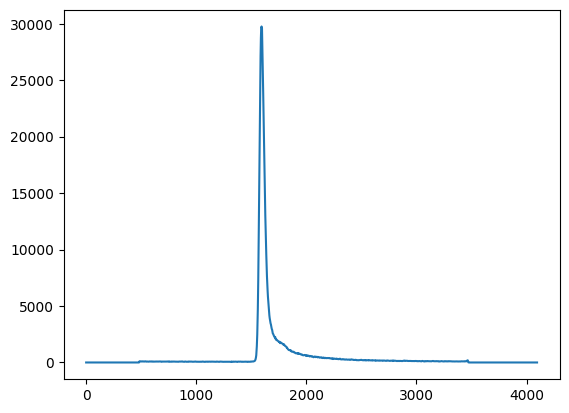

In [6]:
i=13
print(tags_data[i])
plt.plot(irfs_data[i])

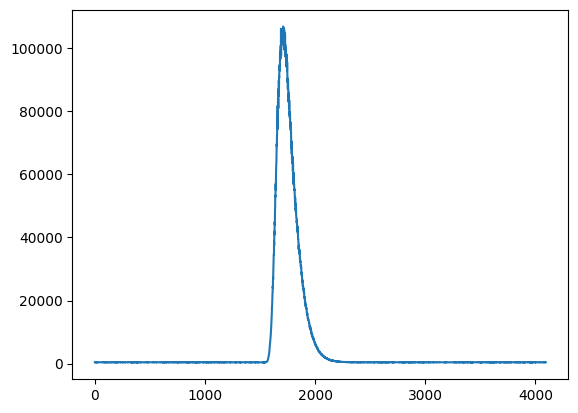

In [7]:
plt.plot(histograms_data[i])

In [8]:
## 2. Split data into training and validation sets
histograms_train, histograms_val, irfs_train, irfs_val, ups_train, ups_val, ua_train, ua_val = train_test_split(
    histograms_data, irfs_data, ups_data, ua_data, test_size=0.2, random_state=42
)

# 3. Create Datasets and DataLoaders
batch_size = 128
epochs_train = 500

train_dataset = phdmodel.TurbidMediaDataset(histograms_train, irfs_train, ups_train, ua_train)
val_dataset = phdmodel.TurbidMediaDataset(histograms_val, irfs_val, ups_val, ua_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 4. Define Network Configuration
network_config = {
        'cnn_filters_hist': [16, 32, 256, 512, 2048], # More CNN filters for histogram branch
        'cnn_filters_irf': [16, 32, 128, 256, 1024],  # More CNN filters for IRF branch
        'kernel_size_cnn': 30,             # Larger kernel size
        'pool_size_cnn': 2,
        'padding_cnn': 2,                 # Adjusted padding for larger kernel
        
        'use_batchnorm_cnn': True,        # <---- Ensure this is True to use BatchNorm in CNNs
        'fc_layer_sizes': [512, 256, 128, 32, 16],  # More FC layers and larger sizes
        'dropout_rate_fc': 0.2,            # Increased dropout rate
        
        'use_rnn': False,              # Use RNN
        'rnn_hidden_dim': 64,        # RNN hidden dimension
        'rnn_layers': 2,               # Number of RNN layers
        'rnn_bidirectional': False,     # Bidirectional RNN
        'rnn_dropout': 0.1,            # RNN dropout
        
        'use_attention': False,        # Enable/disable the attention mechanism over RNN outputs        
    }

# 5. Initialize Model, Loss function, Optimizer, and Scheduler
model = phdmodel.OpticalPropertiesEstimator(network_config)
#criterion = MSELossWeightedUA(ua_weight=1000.0)
#criterion = MAELossWeightedUA(ua_weight=1000.0) # Example using MAE
criterion = phdmodel.HuberLossWeightedUA(delta=1.0, ua_weight=1000.0) # Example using Huber loss

#optimizer = optim.Adam(model.parameters(), lr=0.002)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize StepLR scheduler - reduce LR by factor of 0.1 every 30 epochs
#scheduler = StepLR(optimizer, step_size=50, gamma=0.8) # <---- Initialize StepLR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# 6. Train the Model (pass scheduler to train_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, train_losses, val_losses, learning_rates = phdmodel.train_model(model, 
                                                                      train_loader, 
                                                                      val_loader, 
                                                                      criterion, 
                                                                      optimizer, 
                                                                      scheduler, 
                                                                      epochs=epochs_train, 
                                                                      device=device, 
                                                                      clip_grad=1.0, 
                                                                      patience=30) # Added scheduler

print("Training finished!")

Epoch 1/500, Train Loss: 368.4251, Val Loss: 496.6042, LR: 0.001000
Epoch 2/500, Train Loss: 344.8997, Val Loss: 436.1385, LR: 0.001000
Epoch 3/500, Train Loss: 333.1072, Val Loss: 382.2948, LR: 0.001000
Epoch 4/500, Train Loss: 266.2926, Val Loss: 331.9097, LR: 0.001000
Epoch 5/500, Train Loss: 249.8295, Val Loss: 289.2620, LR: 0.001000
Epoch 6/500, Train Loss: 216.2431, Val Loss: 247.8811, LR: 0.001000
Epoch 7/500, Train Loss: 200.8749, Val Loss: 216.1626, LR: 0.001000
Epoch 8/500, Train Loss: 185.4452, Val Loss: 202.1581, LR: 0.001000
Epoch 9/500, Train Loss: 162.1637, Val Loss: 198.0591, LR: 0.001000
Epoch 10/500, Train Loss: 155.3692, Val Loss: 151.8335, LR: 0.001000
Epoch 11/500, Train Loss: 146.1668, Val Loss: 128.7544, LR: 0.001000
Epoch 12/500, Train Loss: 128.6901, Val Loss: 112.1201, LR: 0.001000
Epoch 13/500, Train Loss: 111.1025, Val Loss: 102.1445, LR: 0.001000
Epoch 14/500, Train Loss: 100.5045, Val Loss: 94.2475, LR: 0.001000
Epoch 15/500, Train Loss: 92.5671, Val Loss:

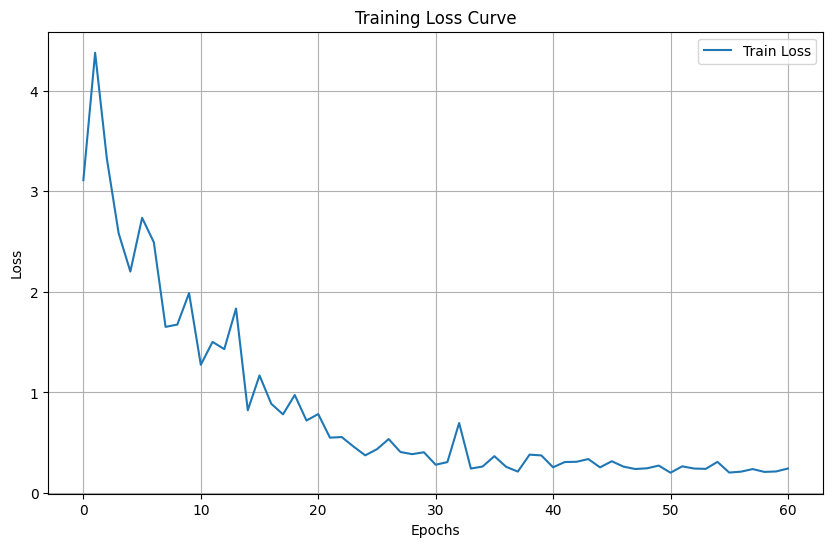

In [9]:
# 9. Plotting Loss Curves
plt.figure(figsize=(10, 6)) # Set figure size for better readability
plt.plot(train_losses[50:], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend() # Show legend to distinguish between train and val loss
plt.grid(True) # Add grid for easier reading
plt.show()    # Display the plot

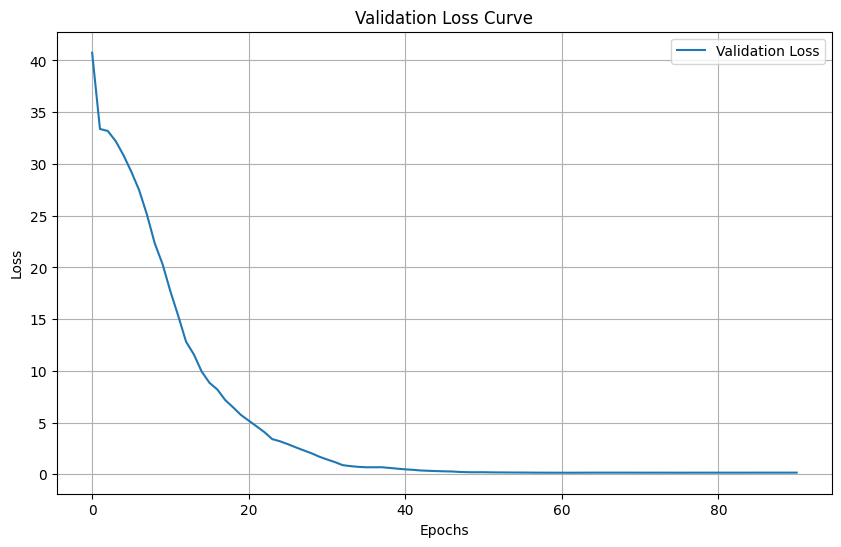

In [10]:
# 9. Plotting Loss Curves
plt.figure(figsize=(10, 6)) # Set figure size for better readability
plt.plot(val_losses[20:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend() # Show legend to distinguish between train and val loss
plt.grid(True) # Add grid for easier reading
plt.show()    # Display the plot

In [11]:
# 6. Example Inference (after training)
#    Load a sample histogram and IRF (e.g., from your validation set or a new measurement)
sample_index = 3 # Example index from validation set


sample_histogram = torch.tensor(phdmodel.normalize_dtof(histograms_val[sample_index]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
sample_irf = torch.tensor(phdmodel.normalize_dtof(irfs_val[sample_index]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

trained_model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_optical_properties = trained_model(sample_histogram, sample_irf)

predicted_ups = predicted_optical_properties[0][0].item()
predicted_ua = predicted_optical_properties[0][1].item()
actual_ups = ups_val[sample_index]
actual_ua = ua_val[sample_index]

print(f"Predicted ups: {predicted_ups:.4f}, Actual ups: {actual_ups:.4f}")
print(f"Predicted ua: {predicted_ua:.4f}, Actual ua: {actual_ua:.4f}")

Predicted ups: 1.1437, Actual ups: 1.7141
Predicted ua: 0.0065, Actual ua: 0.0147


Median error in ups: 40.20 %
Median error in ua: 57.32 %


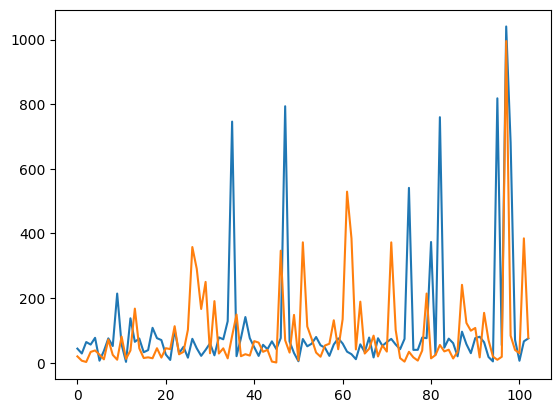

In [12]:
error_ua = []
error_ups = []
actual_uas = []
actual_upss = []

for i in range(len(histograms_val)):
    sample_histogram = torch.tensor(phdmodel.normalize_dtof(histograms_val[i]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
    sample_irf = torch.tensor(phdmodel.normalize_dtof(irfs_val[i]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

    trained_model.eval() # Set model to evaluation mode
    with torch.no_grad():
        predicted_optical_properties = trained_model(sample_histogram, sample_irf)

    predicted_ups = predicted_optical_properties[0][0].item()
    predicted_ua = predicted_optical_properties[0][1].item()
    actual_ups = ups_val[i]
    actual_ua = ua_val[i]

    actual_uas.append(actual_ua)
    actual_upss.append(actual_ups)

    error_ua.append(abs((actual_ua - predicted_ua)/actual_ua)*100)
    error_ups.append(abs((actual_ups - predicted_ups)/actual_ups)*100)
    

print("Median error in ups: {:.2f} %".format(np.nanmedian(error_ups)))
print("Median error in ua: {:.2f} %".format(np.nanmedian(error_ua)))

plt.plot(error_ua, label='Error in ua')
plt.plot(error_ups, label='Error in ups')

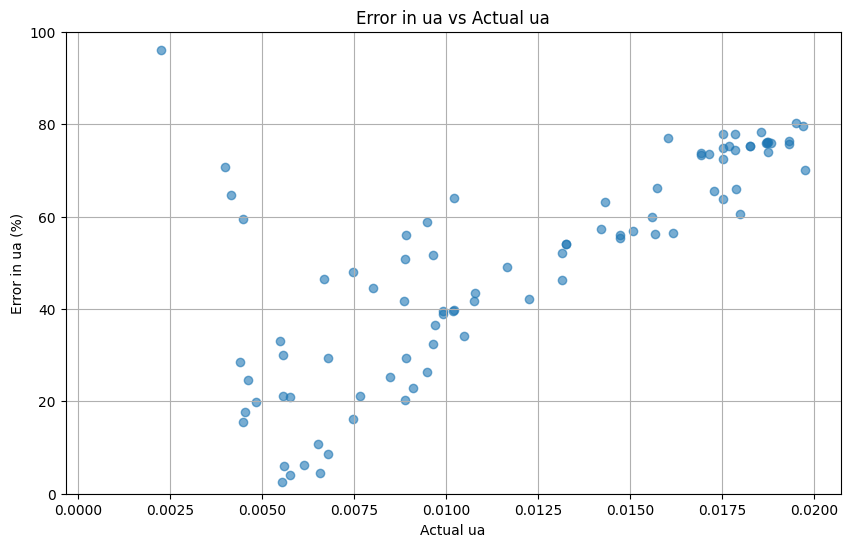

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_uas, error_ua, alpha=0.6)
plt.xlabel('Actual ua')
plt.ylabel('Error in ua (%)')
plt.ylim(0, 100)
plt.title('Error in ua vs Actual ua')
plt.grid(True)
plt.show()

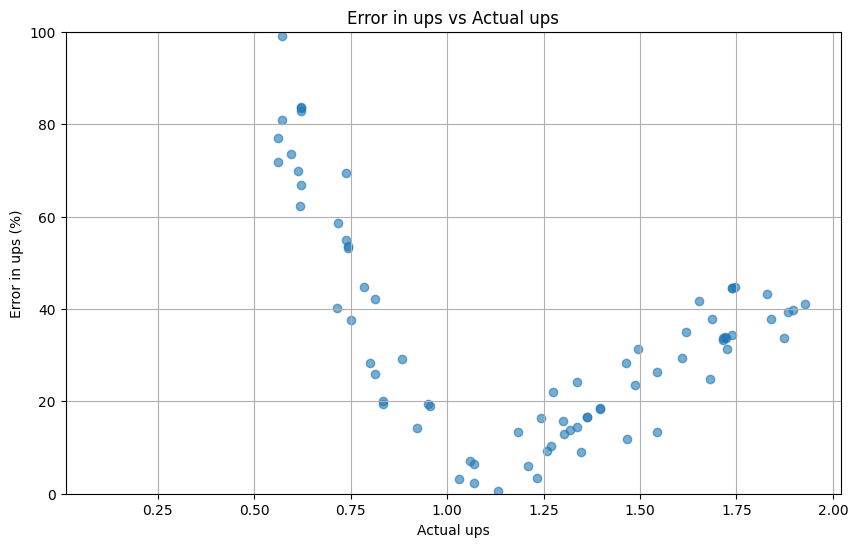

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_upss, error_ups, alpha=0.6)
plt.xlabel('Actual ups')
plt.ylabel('Error in ups (%)')
plt.ylim(0, 100)
plt.title('Error in ups vs Actual ups')
plt.grid(True)
plt.show()

2D Filled Contour plot generated and saved as tricontourf_plot_2d.png


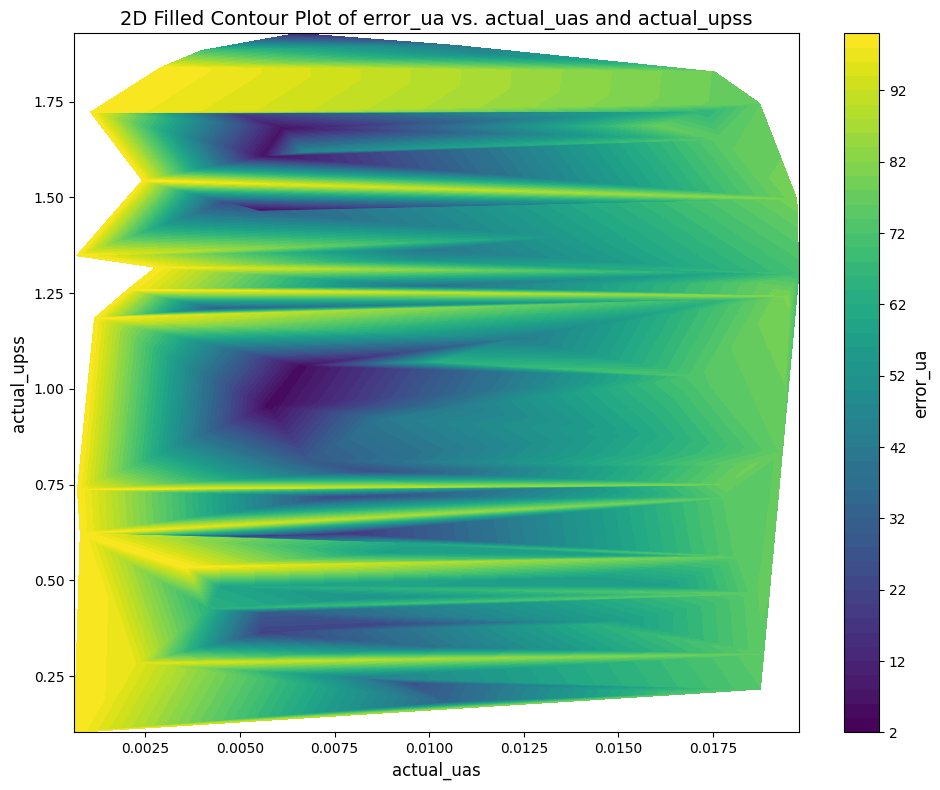

In [15]:
# --- Creating the 2D Filled Contour Plot ---
plt.figure(figsize=(10, 8))

# Create the filled contour plot
# actual_uas for x-axis, actual_upss for y-axis, error_ua for contour levels/colors
# levels specifies the number of contour levels or a list of explicit levels
# cmap='viridis' sets the colormap

actual_uas_np = np.array(actual_uas)
actual_upss_np = np.array(actual_upss)
error_ua_np = np.array(error_ua)
error_ua_np[error_ua_np > 100] = 100 # Cap the error at 100 for better visualization

# --- Identify and filter out non-finite values using the NumPy arrays ---
# finite_mask will be a NumPy boolean array
finite_mask = np.isfinite(error_ua_np)

# Apply the boolean mask to the NumPy arrays
actual_uas_clean = actual_uas_np[finite_mask]
actual_upss_clean = actual_upss_np[finite_mask]
error_ua_clean = error_ua_np[finite_mask]

contour = plt.tricontourf(actual_uas_clean, actual_upss_clean, error_ua_clean, levels=50, cmap='viridis')

# Optionally, you can add contour lines
# plt.tricontour(actual_uas, actual_upss, error_ua, levels=15, colors='k', linewidths=0.5)

# --- Adding Labels and Title ---
plt.xlabel('actual_uas', fontsize=12)
plt.ylabel('actual_upss', fontsize=12)
plt.title('2D Filled Contour Plot of error_ua vs. actual_uas and actual_upss', fontsize=14)

# --- Adding a Color Bar ---
cbar = plt.colorbar(contour, label='error_ua')
cbar.set_label('error_ua', fontsize=12)

# --- Display the Plot ---
plt.tight_layout()
plt.savefig('tricontourf_plot_2d.png', dpi=300)
# plt.show()
print("2D Filled Contour plot generated and saved as tricontourf_plot_2d.png")

2D Filled Contour plot generated and saved as tricontourf_plot_2d.png


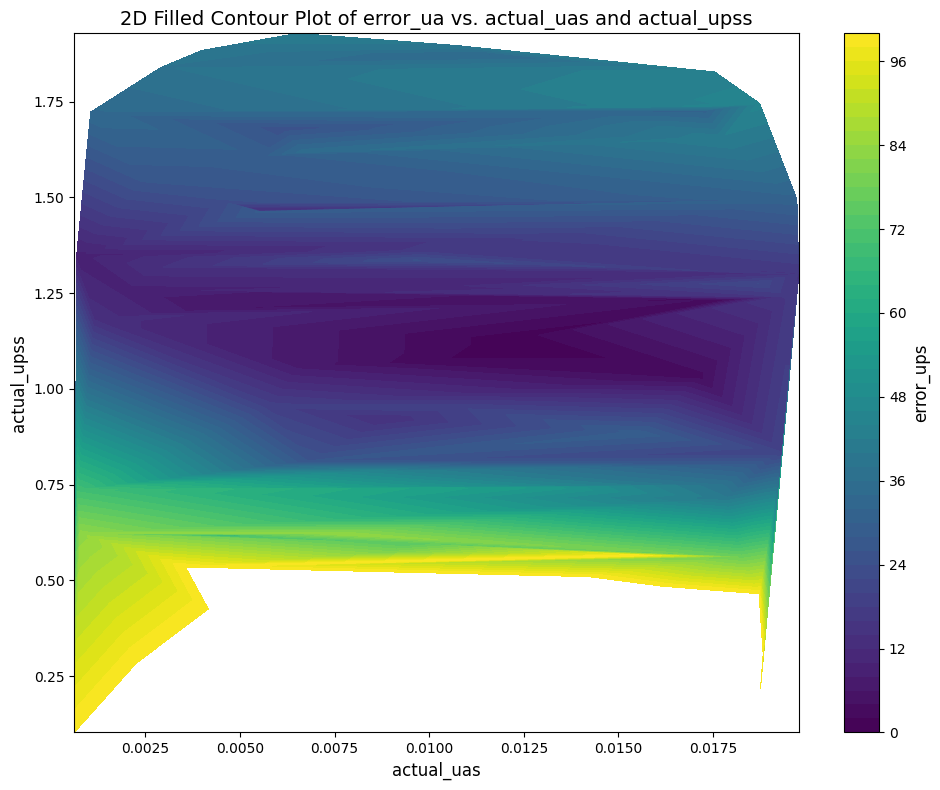

In [16]:
# --- Creating the 2D Filled Contour Plot ---
plt.figure(figsize=(10, 8))

# Create the filled contour plot
# actual_uas for x-axis, actual_upss for y-axis, error_ua for contour levels/colors
# levels specifies the number of contour levels or a list of explicit levels
# cmap='viridis' sets the colormap

actual_uas_np = np.array(actual_uas)
actual_upss_np = np.array(actual_upss)
error_ups_np = np.array(error_ups)
error_ups_np[error_ups_np > 100] = 100 # Cap the error at 100 for better visualization

# --- Identify and filter out non-finite values using the NumPy arrays ---
# finite_mask will be a NumPy boolean array
finite_mask = np.isfinite(error_ups_np)

# Apply the boolean mask to the NumPy arrays
actual_uas_clean = actual_uas_np[finite_mask]
actual_upss_clean = actual_upss_np[finite_mask]
error_ups_clean = error_ups_np[finite_mask]

contour = plt.tricontourf(actual_uas_clean, actual_upss_clean, error_ups_clean, levels=50, cmap='viridis')

# Optionally, you can add contour lines
# plt.tricontour(actual_uas, actual_upss, error_ua, levels=15, colors='k', linewidths=0.5)

# --- Adding Labels and Title ---
plt.xlabel('actual_uas', fontsize=12)
plt.ylabel('actual_upss', fontsize=12)
plt.title('2D Filled Contour Plot of error_ua vs. actual_uas and actual_upss', fontsize=14)

# --- Adding a Color Bar ---
cbar = plt.colorbar(contour, label='error_ups')
cbar.set_label('error_ups', fontsize=12)

# --- Display the Plot ---
plt.tight_layout()
plt.savefig('tricontourf_plot_2d.png', dpi=300)
# plt.show()
print("2D Filled Contour plot generated and saved as tricontourf_plot_2d.png")

In [17]:
# Save the trained model and hyperparameters
import time
import json

model_folder = "TrainedModels/rho" + str(rho) + "mm"
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

date_time = time.strftime("%Y%m%d%H%M%S")
config_path = '{}/optical_propierties_estimator_config_{}.json'.format(model_folder,date_time)
with open(config_path, 'w') as f:
    json.dump(network_config, f, indent=4) # Save with indent for readability
torch.save(trained_model.state_dict(), '{}/optical_properties_estimator_weights_{}.pth'.format(model_folder,date_time))